In [1]:
EPOCHS = 30
LEARNING_RATE = 0.001
BATCH_SIZE = 10
DROPOUT_RATE = 0.5
MODEL_PATH = '/tmp/model.ckpt'
NOTES = ''

In [2]:
import os.path
import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests


In [3]:
import os
import matplotlib.pyplot as plt
import subprocess as sp
from datetime import datetime
from tqdm import tqdm
import cv2
import numpy as np
import shutil
import scipy

In [4]:

# Check TensorFlow Version                                                                                                                                              
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU                                                                                                                                                       
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


In [5]:
vgg_path = '/home/diogoaos/P2/CarND-Semantic-Segmentation/data/vgg'

In [6]:
def load_vgg(sess, vgg_path):
    """                                                                                                                                                                 
    Load Pretrained VGG Model into TensorFlow.                                                                                                                          
    :param sess: TensorFlow Session                                                                                                                                     
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"                                                                                   
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)                                                               
    """
    # TODO: Implement function                                                                                                                                          
    #   Use tf.saved_model.loader.load to load the model and weights                                                                                                    
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'                                                                                                                         
    
    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    g = tf.get_default_graph()
    input_layer = g.get_tensor_by_name(vgg_input_tensor_name)
    keep_prob = g.get_tensor_by_name(vgg_keep_prob_tensor_name)
    l3 = g.get_tensor_by_name(vgg_layer3_out_tensor_name)
    l4 = g.get_tensor_by_name(vgg_layer4_out_tensor_name)
    l7 = g.get_tensor_by_name(vgg_layer7_out_tensor_name)
    
    return input_layer, keep_prob, l3, l4, l7
print('load vgg: ', end='')
tests.test_load_vgg(load_vgg, tf)

load vgg: Tests Passed


In [7]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """                                                                                                                                                                 
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.                                                                       
    :param vgg_layer3_out: TF Tensor for VGG Layer 3 output                                                                                                             
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output                                                                                                             
    :param vgg_layer7_out: TF Tensor for VGG Layer 7 output                                                                                                             
    :param num_classes: Number of classes to classify                                                                                                                   
    :return: The Tensor for the last layer of output                                                                                                                    
    """
    # at the end of VGG16, the image has been downsampled to 1/32th of original size
    # Part1 (upsample 2x, final=2x):
    #   conv 1x1 of layer7
    #   upsample 2x previous
    #   conv 1x1 layer4
    #   add them
    # Part2 (upsample 2x, final=4x):
    #   upsample 2x Part1
    #   conv 1x1 layer3
    #   add them
    # Part3 (upsample 8x, final=32x):
    #   upsample Part2 8x
    
    # TODO: Implement function
    # 1 by 1 convolution from VGG output
    # stride is what is upsmapling, padding must be same, size may change
    # use regulizer to everylayer according to Aron
    # the regulizer penalizes when the weights get too large
    l7_conv_1x1 = tf.layers.conv2d(vgg_layer7_out,
                                filters=num_classes,
                                kernel_size=1,
                                strides=(1,1),
                                padding='same',
                                kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    #fcn32 = tf.layers.conv2d_transpose(l7_conv_1x1,
    #                                    filters=num_classes,
    #                                    kernel_size=64,
    #                                    strides=32,
    #                                    padding='same',
    #                                    kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    l4_conv_1x1 = tf.layers.conv2d(vgg_layer4_out,
                                filters=num_classes,
                                kernel_size=1,
                                strides=(1,1),
                                padding='same',
                                kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    l3_conv_1x1 = tf.layers.conv2d(vgg_layer3_out,
                                filters=num_classes,
                                kernel_size=1,
                                strides=(1,1),
                                padding='same',
                                kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    # second layer is transposed convolution from 1 by 1 convolution
    # we want to upsample x2 and then skip layer 4
    fcn16 = tf.layers.conv2d_transpose(l7_conv_1x1,
                                        filters=num_classes,
                                        kernel_size=4,
                                        strides=2,
                                        padding='same',
                                        kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    fcn16 = tf.add(fcn16, l4_conv_1x1)
    #fcn16 = tf.layers.conv2d_transpose(fcn16,
    #                                    filters=num_classes,
    #                                    kernel_size=32,
    #                                    strides=16,
    #                                    padding='same',
    #                                    kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    
    # next we want to again upsample x2 (total 4x),
    # skip upsampled layer 4 (upsample x2)
    # skip layer 3
    fcn8 = tf.layers.conv2d_transpose(fcn16,
                                        filters=num_classes,
                                        kernel_size=4,
                                        strides=2,
                                        padding='same',
                                        kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    fcn8 = tf.add(fcn8, l3_conv_1x1)
    fcn8 = tf.layers.conv2d_transpose(fcn8,
                                        filters=num_classes,
                                        kernel_size=16,
                                        strides=8,
                                        padding='same',
                                        kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    
    return fcn8
print('layers: ', end='')
tests.test_layers(layers)

layers: Tests Passed


In [8]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """                                                                                                                                                                 
    Build the TensorFLow loss and optimizer operations.                                                                                                                 
    :param nn_last_layer: TF Tensor of the last layer in the neural network                                                                                             
    :param correct_label: TF Placeholder for the correct label image                                                                                                    
    :param learning_rate: TF Placeholder for the learning rate                                                                                                          
    :param num_classes: Number of classes to classify                                                                                                                   
    :return: Tuple of (logits, train_op, cross_entropy_loss)                                                                                                            
    """
    # logits : 2D tensor; rows=pixels; columns=pixel classes
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    correct_label = tf.reshape(correct_label, (-1,num_classes))
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=correct_label)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss_operation)
    return logits, train_op, loss_operation
tests.test_optimize(optimize)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Tests Passed


In [9]:
def save_results():
    time_str = datetime.now().strftime("%d_%m_%Y__%H_%M")
    out_dir = 'results/' + time_str
    os.mkdir(out_dir)
    file_out = os.path.join(out_dir, time_str + '.txt')
    plot_fn = os.path.join(out_dir, 'loss.png')
    
    FPS = 4
    video_avi_fn = os.path.join(out_dir, 'inference.avi')
    video_mp4_fn = os.path.join(out_dir, 'inference.mp4')

    
    with open(file_out, 'w') as f:
        f.write("epochs={}, learning_rate={}, batch_size={}, dropout_rate={}\n".format(
                 EPOCHS, LEARNING_RATE, BATCH_SIZE, DROPOUT_RATE))
        f.write('notes:' + NOTES + '\n')
        
    def update(epoch, bs, loss):
        with open(file_out, 'a') as f:
            f.write('epoch={}\n'.format(epoch))
            f.write('batch_sizes={}\n'.format(bs))
            f.write('loss={}\n'.format(loss))
    

    def save_plot():
        with open(file_out, 'r') as f:
            header = f.readline()
            data = f.read()
        data = data.split('epoch=')[1:]
        epoch_loss = []
        for d in data:
            bs_idx_start = d.find('batch_sizes=[') + len('batch_sizes=[')
            bs_idx_end = d.find(']\nloss')
            l_idx_start = d.find('loss=[') + len('loss=[')
            l_idx_end = d.find(']', l_idx_start)
            bs = d[bs_idx_start: bs_idx_end]
            bs = list(map(int, bs.split(',')))
            l = d[l_idx_start: l_idx_end]
            l = list(map(float, l.split(',')))
            assert len(bs) == len(l)
            total_images = sum(bs)
            total_loss = sum(l)
            average_loss = total_loss / total_images
            epoch_loss.append(average_loss)
        
        plt.plot(epoch_loss, label='training')
        plt.xlabel('epoch')
        plt.ylabel('mean cross entropy loss')
        plt.title(header)
        plt.legend()
        plt.savefig(plot_fn)
        
    def save_video():
        test_out_dirs = os.listdir('runs/')
        test_out_dir = os.path.join('runs', test_out_dirs[-1])
        images_fn = os.listdir(test_out_dir)
        images_fn = sorted(images_fn)
        
        def process(im, txt):
            height, width, channel = im.shape
            text_height = 40
            img = np.zeros((height + text_height,width,channel), np.uint8)
            img[0:height] = im[:]
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(img, txt,(int(width/2) - int(width/5),height + text_height - 10), font, 1,(255,0,0),2,cv2.LINE_AA)
            return img
        
        im = cv2.imread(os.path.join(test_out_dir, images_fn[0]))
        im = process(im, 'X')
        height, width, channel = im.shape

        fourcc = cv2.VideoWriter_fourcc(*'MP42')
        video = cv2.VideoWriter(video_avi_fn, fourcc, float(FPS), (width, height))

        for im_fn in images_fn:
            frame = cv2.imread(os.path.join(test_out_dir, im_fn))
            video.write(process(frame, im_fn))
        video.release()
        
        sp.Popen(['ffmpeg', '-i', video_avi_fn, video_mp4_fn])
        
        for d in test_out_dirs:
            shutil.rmtree(os.path.join('runs', d))
    
    return update, save_plot, save_video, out_dir

In [10]:
update, save_plot, save_video, out_dir = save_results()
MODEL_PATH = os.path.join(out_dir, 'model.ckpt')

In [11]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """                                                                                                                                                                 
    Train neural network and print out the loss during training.                                                                                                        
    :param sess: TF Session                                                                                                                                             
    :param epochs: Number of epochs                                                                                                                                     
    :param batch_size: Batch size                                                                                                                                       
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)                                                             
    :param train_op: TF Operation to train the neural network                                                                                                           
    :param cross_entropy_loss: TF Tensor for the amount of loss                                                                                                         
    :param input_image: TF Placeholder for input images                                                                                                                 
    :param correct_label: TF Placeholder for label images                                                                                                               
    :param keep_prob: TF Placeholder for dropout keep probability                                                                                                       
    :param learning_rate: TF Placeholder for learning rate                                                                                                              
    """
    pbar = tqdm(total=epochs)
    all_size = []
    all_loss = []
    for epoch in range(epochs):
        epoch_batch_size = []
        epoch_loss = []
        for image, label in get_batches_fn(batch_size):
            # create feed dict: input image, correct label, keep prob, learning rate
            # loss = session.run
            feed_dict = {input_image: image,
                         correct_label: label,
                         keep_prob: DROPOUT_RATE,
                         learning_rate: LEARNING_RATE}
            _, loss = sess.run([train_op, cross_entropy_loss], feed_dict=feed_dict)
            epoch_batch_size.append(len(image))
            epoch_loss.append(loss)
        all_loss.append(epoch_batch_size)
        all_loss.append(epoch_loss)
        print('epoch {}/{} | {} images | loss {}'.format(epoch, epochs,sum(epoch_batch_size), sum(epoch_loss) / sum(epoch_batch_size)))
        update(epoch, epoch_batch_size, epoch_loss)
        pbar.update(1)
    pass
tests.test_train_nn(train_nn)

100%|██████████| 1/1 [00:00<00:00, 166.73it/s]


INFO:tensorflow:Restoring parameters from ./data/vgg/variables/variables
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from ./data/vgg/variables/variables
INFO:tensorflow:Restoring parameters from results/29_03_2019__18_38/model.ckpt


In [12]:
def run():
    num_classes = 2
    image_shape = (160, 576)  # KITTI dataset uses 160x576 images                                                                                                       
    data_dir = './data'
    runs_dir = './runs'
    tests.test_for_kitti_dataset(data_dir)

    # Download pretrained vgg model                                                                                                                                     
    helper.maybe_download_pretrained_vgg(data_dir)

    # OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.                                                                             
    # You'll need a GPU with at least 10 teraFLOPS to train on.                                                                                                         
    #  https://www.cityscapes-dataset.com/
    
    
    
    with tf.Session() as sess:
        print('setup...')
        label_layer = tf.placeholder(tf.int32, (None, None, None, num_classes), name='gt_label')
        learning_rate = tf.placeholder(tf.float32, name='learning_rate')
        
        # Path to vgg model                                                                                                                                             
        vgg_path = os.path.join(data_dir, 'vgg')
        # Create function to get batches                                                                                                                                
        get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)

        # OPTIONAL: Augment Images for better results                                                                                                                   
        #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network                                                        

        # TODO: Build NN using load_vgg, layers, and optimize function
        input_image, keep_prob, layer3, layer4, layer7 = load_vgg(sess, vgg_path)
        layer_output = layers(layer3, layer4, layer7, num_classes)

        # TODO: Train NN using the train_nn function
        
        logits, train_op, cross_entropy_loss = optimize(layer_output, label_layer, learning_rate, num_classes )
        
        print('training...')
        init_op = tf.initialize_all_variables()
        sess.run(init_op)
        
        
        train_nn(sess, EPOCHS, BATCH_SIZE, get_batches_fn, train_op, cross_entropy_loss,
                 input_image, label_layer, keep_prob, learning_rate)
        
        saver = tf.train.Saver()
        save_path = saver.save(sess, MODEL_PATH)

        print('inference on test images...')
        helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)                                                         
        
        print('saving plot...')
        save_plot()
        print('saving video...')
        save_video()

        # OPTIONAL: Apply the trained model to a video

100%|██████████| 30/30 [09:23<00:00, 18.77s/it]

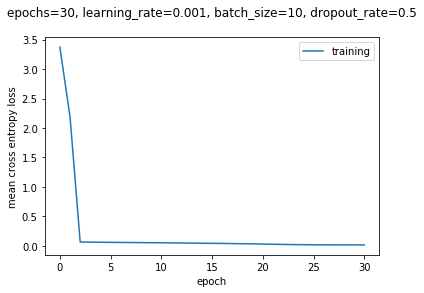

In [13]:
run()

# Video

In [14]:
import sys
sys.stdout = sys.__stdout__

In [15]:
def inference_on_image(sess, logits, keep_prob, image_input, image, image_shape):
    """
    Generate test output using the test images
    :param sess: TF session
    :param logits: TF Tensor for the logits
    :param keep_prob: TF Placeholder for the dropout keep probability
    :param image_pl: TF Placeholder for the image placeholder
    :param data_folder: Path to the folder that contains the datasets
    :param image_shape: Tuple - Shape of image
    :return: Output for for each test image
    """
    image = scipy.misc.imresize(image, image_shape)

    # Run inference
    im_softmax = sess.run(
        [tf.nn.softmax(logits)],
        {keep_prob: 1.0, image_input: [image]})
    # Splice out second column (road), reshape output back to image_shape
    im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
    # If road softmax > 0.5, prediction is road
    segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
    # Create mask based on segmentation to apply to original image
    mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
    mask = scipy.misc.toimage(mask, mode="RGBA")
    street_im = scipy.misc.toimage(image)
    street_im.paste(mask, box=None, mask=mask)

    return np.array(street_im)

In [16]:
def info_video(video_in_fn):
    cap = cv2.VideoCapture(video_in_fn)
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    cap.release()
    
    return n_frames, fps

In [17]:
def load_video(video_in_fn):
    cap = cv2.VideoCapture(video_in_fn)
    # Check if camera opened successfully
    if (cap.isOpened()== False): 
        raise Exception("Error opening video stream or file")

    # Read until video is completed
    while(cap.isOpened()):
        # Capture frame-by-frame
        ret, frame = cap.read()
        if frame is None:
            break
        yield frame

    # When everything done, release the video capture object
    cap.release()

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline


In [19]:
input_videos = ['data/neuronios.mp4']

In [20]:
data_dir = './data'
vgg_path = os.path.join(data_dir, 'vgg')

OUT_DIR = 'results/29_03_2019__14_15'

In [21]:
def process_video(video_fn, model_dir, out_dir_param):
    model_fn = os.path.join(model_dir, 'model.ckpt')
    video_in_fn_suffix = video_fn.split('/')[-1]
    video_in_fn_suffix = video_in_fn_suffix.split('.')[0]
    video_out_fn = os.path.join(out_dir_param, 'processed_' + video_in_fn_suffix + '.avi')

    n_frames, fps = info_video(video_fn)
    image_shape = (160, 576)
    num_classes = 2
    height, width = image_shape

    # reset graph
    tf.reset_default_graph()

    with tf.Session() as sess:
        # load model
        input_image, keep_prob, layer3, layer4, layer7 = load_vgg(sess, vgg_path)
        layer_output = layers(layer3, layer4, layer7, num_classes)
        logits = tf.reshape(layer_output, (-1, num_classes))

        # restore variables
        saver = tf.train.Saver()
        saver.restore(sess, model_fn)

        fourcc = cv2.VideoWriter_fourcc(*'MP42')
        video_out = cv2.VideoWriter(video_out_fn, fourcc, float(fps), (width, height))

        video_in = load_video(video_fn)
        pbar = tqdm(total=n_frames)
        for frame in video_in:
            inf_frame = inference_on_image(sess, logits, keep_prob, input_image, frame, image_shape)
            video_out.write(inf_frame)
            pbar.update(1)

        video_out.release()

In [22]:
for v_fn in input_videos:
    process_video(v_fn, out_dir, out_dir)


  0%|          | 0/673 [00:00<?, ?it/s]/home/diogoaos/p2/lib/python3.5/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  if sys.path[0] == '':
/home/diogoaos/p2/lib/python3.5/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
/home/diogoaos/p2/lib/python3.5/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.

 21%|██        | 141/673 [00:23<01:28,  6.00it/s]


 44%|████▍     | 295/673 [00:49<01:05,  5.74it/s]


 67%|██████▋   | 449/673 [01:16<00:40,  5.51it/s]


 90%|████████▉ | 603/673 [01:44<00:13,  5.36it/s]


100%|██████████| 673/673 [01:58<00:00,  5.20it/s]